In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import warnings
warnings.filterwarnings("ignore")

from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from plotly import io as pio
pio.templates.default = 'plotly_dark'

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression 
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras import metrics

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import pandas_datareader.data as web

from eli5.sklearn import PermutationImportance
import eli5
import shap

Using TensorFlow backend.


In [2]:
class Stock():
    """get, engineer, scale, split data for ML and DL"""
    
    def __init__(self, ticker="AAPL", start=dt.datetime(2000,1,1), end=dt.datetime(2000,1,1)):
        """initialize"""
        self.data = web.DataReader(ticker, "yahoo", dt.datetime(2000,1,1), dt.datetime(2020,1,1))
        self.data.index = pd.to_datetime(self.data.index)
        self.data = self.data.sort_index()
        self.data.drop("Adj Close", axis=1, inplace=True)
        self.data.columns = ['high', 'low', 'open', 'close', 'volume']
        
        """engineer target here"""
        self.data["mean5"] = self.data["close"].rolling(5).mean()
        self.data["shift"] = self.data["close"].shift(-3)
        self.data.dropna(inplace=True)
        self.data["y"] = (self.data["shift"] > self.data["mean5"])*1
        self.data.drop(["shift", "mean5"], axis=1, inplace=True)
    
    def get(self):
        return self.data
    
    def set(self, data):
        self.data = data
        
    def engineer(self, engineers):
        for engineer in engineers:
            self.data = engineer(self.data)
        self.data.dropna(inplace=True)
        
    def validate(self,model=None, metric=accuracy_score, scale=False, look_back=None):
        kfolder = StratifiedKFold(shuffle=True)
        x, y = self.data[[col for col in self.data.columns if col != "y"]].values, self.data["y"].values
        train_scores, val_scores = [], []
        for train_idx, val_idx in kfolder.split(x, y):
            x_train, y_train, x_val, y_val = x[train_idx], y[train_idx], x[val_idx], y[val_idx]
            if scale:
                scaler = StandardScaler()
                x_train = scaler.fit_transform(x_train)
                x_val = scaler.transform(x_val)
            if look_back:
                x_train, y_train = self._look_back(x_train, y_train, look_back)
                x_val, y_val = self._look_back(x_val, y_val, look_back)
            model.fit(x_train, y_train)
            train_scores.append(metric(model.predict(x_train), y_train))
            val_scores.append(metric(model.predict(x_val), y_val))
        train_scores = np.array(train_scores)
        val_scores = np.array(val_scores)
        return "train {} +/- {}, validation {} +/- {}".format(train_scores.mean(), train_scores.std(), val_scores.mean(), val_scores.std())
    
    def split(self, train_size=.9, scale=False, look_back=None):
        x, y = self.data[[col for col in self.data.columns if col != "y"]].values, self.data["y"].values
        x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=train_size, stratify=y)
        if scale:
                scaler = StandardScaler()
                x_train = scaler.fit_transform(x_train)
                x_val = scaler.transform(x_val)
        if look_back:
            x_train, y_train = self._look_back(x_train, y_train, look_back)
            x_val, y_val = self._look_back(x_val, y_val, look_back)
        return x_train, y_train, x_val, y_val
    
    def _look_back(self, x, y, look_back=3):
        samples = []
        for idx,row in enumerate(x):
            if idx<look_back-1:
                continue
            else:
                samples.append(x[idx-look_back+1:idx+1])
        return np.array(samples), y[look_back-1:]

In [3]:
class EDA:
    """EDA"""
    def __init__(self,data):
        self.data = data.copy()
        
    def show_candlesticks(self, moving_avgs=[5], ewms=[5]):
        fig = go.Figure()
        fig.add_trace(go.Candlestick(x=self.data.index,
                                 low=self.data["low"],
                                 open=self.data["open"],
                                 high=self.data["high"],
                                 close=self.data["close"]))
        
        for moving_avg in moving_avgs:
            fig.add_trace(go.Scatter(name="mavg"+str(moving_avg), mode="lines", x=self.data.index, y=self.data["close"].rolling(moving_avg).mean()))
            
        for ewm in ewms:
            fig.add_trace(go.Scatter(name="ewm"+str(ewm), mode="lines", x=self.data.index, y=self.data["close"].ewm(ewm).mean()))
            
        fig.update_layout(xaxis_rangeslider_visible=False)
        fig.show()
        
    def chek_stationarity(self, cols=["open", "close", "high", "low", "volume"]):
        for col in cols:
            self.data[col].plot(label=col)
            plt.plot()
            plt.plot(self.data.index, self.data[col].rolling(90).mean(), label="mean")
            plt.plot(self.data.index, self.data[col].rolling(90).std(), label="std")
            plt.title(col+" dicki_fuller_p_value: "+str(adfuller(self.data[col])[1]))
            plt.legend()
            plt.show()
            
    def plot_acf_pacf(self, cols=["low", "volume"]):
        for col in cols:
            plot_acf(self.data["low"], lags=50, title=col+" "+"acf")
            plot_pacf(self.data["low"], lags=50, title=col+" "+"pacf")


In [4]:
class Engineer:
    """Feature Engineering"""
    
    def base(data):
        data = data.copy()
        data["bbase_mean"] = data[["close","open"]].mean(axis=1)
        data["base_mean"] = data[["close","open","high","low"]].mean(axis=1)
        data["bbase_base"] = data["bbase_mean"] - data["base_mean"]
        data["day"] = data.index.day
        data["week"] = data.index.week
        data["weekday"] = data.index.weekday
        data["month"] = data.index.month
        data["year"] = data.index.year
        return data
        
    def lags(data):
        data = data.copy()
        for i in range(1,20):
            if i % 3 == 0:
                data["base_mean"+"_lag"+str(i)] = data["base_mean"].shift(i)
        
        for i in range(1,25):
            if i % 4 == 0:
                data["close"+"_lag"+str(i)] = data["close"].shift(i)
        return data
    
    def pct_changes(data):
        data = data.copy()
        for i in range(3, 20):
            if i%3 == 0:
                for col in ["bbase_mean", "close", "volume"]:
                    data[col+"pct"+str(i)] = data[col].pct_change(i)    
        return data
    
    
    def logs(data):
        data = data.copy()
        for col in ["base_mean", "bbase_mean", "open", "high", "close", "low"]:
            data[col+"_log"] = data[col].apply(np.log)
        return data

    def candelestick(data):
        data = data.copy()
        data["range"] = data["high"] - data["low"]
        data["body"] = data["close"] - data["open"]
        for period in [3,5,10,15]:
            data["body_pow3_sum"+str(period)] = np.power(data["body"].rolling(period).sum(), 3)
        data["upper_wick"] = data.apply(lambda x: x["high"]-x["close"] if x["body"]>0 else x["high"]-x["open"], axis=1)
        data["lower_wick"] = data.apply(lambda x: x["open"]-x["low"] if x["body"]<=0 else x["close"]-x["low"], axis=1)
        for col in ["body", "lower_wick", "upper_wick"]:
            data[col+"_to_range"] = np.abs(data[col]) / data["range"]
            data[col+"_to_mean5"] = np.abs(data[col]) / np.abs(data[col]).rolling(5).mean()
            data[col+"_to_mean10"] = np.abs(data[col]) / np.abs(data[col]).rolling(10).mean()
        return data
    
    def moving_avgs_ratios(data):
        data = data.copy()
        for col in ["open", "close","high", "low", "volume"]:
            for period in [5,10,20,30]:
                data[col+"_ma"+str(period)] = data[col].rolling(period).mean()
                data[col+"_to_ma"+str(period)] = data[col] / data[col+"_ma"+str(period)]
        for col in ["high","open","high", "low", "volume"]:
            data[col+"_ma"+"5_to_10"] = data[col+"_ma5"] / data[col+"_ma10"]
            data[col+"_ma"+"5_to_20"] = data[col+"_ma5"] / data[col+"_ma20"]
            data[col+"_ma"+"10_to_20"] = data[col+"_ma10"] / data[col+"_ma20"]
            data[col+"_ma"+"10_to_30"] = data[col+"_ma10"] / data[col+"_ma30"]
        for col in ["open", "close","high", "low", "volume"]:
            for period in [5,10,20,30]:
                data[col+"_ema"+str(period)] = data[col].ewm(period).mean()
                data[col+"_to_ema"+str(period)] = data[col] / data[col+"_ema"+str(period)]
        return data
    
    def to_month_year_max_min(data):
        data = data.copy()
        data["year_max"] = data.groupby("year")["high"].transform(lambda x: x.max())
        data["month_max"] = data.groupby(["year","month"])["high"].transform(lambda x:x.max())
        data["year_min"] = data.groupby("year")["low"].transform(lambda x: x.min())
        data["month_min"] = data.groupby(["year","month"])["low"].transform(lambda x:x.min())
        for col in ["year_max", "year_min", "month_max", "month_min"]:
            data["bbase_to_"+col] = data["bbase_mean"] / data[col]
        return data
    
    def seasonality_month_week(data):
        data = data.copy()
        for col in ["base_mean", "close"]:
            # first(last) days of months
            data[col+"_gr_day"] = data.groupby(["day","year"])[col].transform(lambda x:x.mean())
            data[col+"_to_gr_day"] = data[col] / data[col+"_gr_day"]
            data[col+"_gr_weekday"] = data.groupby(["weekday","year"])[col].transform(lambda x:x.mean())
            data[col+"_to_gr_weekday"] = data[col] / data[col+"_gr_weekday"]
        return data
    
    def belkhayate_gravity_center(data):
        data = data.copy()
        for alpha in [.236, .382, .618, .786]:
            data["belkhayate+"+str(alpha*1000)] = data["base_mean"] / (data["base_mean"].rolling(30).mean() + alpha * data["base_mean"].rolling(30).std())
            data["belkhayate_"+str(alpha*1000)] = data["base_mean"] / (data["base_mean"].rolling(30).mean() - alpha * data["base_mean"].rolling(30).std())
        return data
            
    def bb(data):
        data = data.copy()
        for period in [15, 30]:
            data["bb"+str(period)] = data["base_mean"] / (data["base_mean"].rolling(period).mean() + 2 * data["base_mean"].rolling(30).std())
            data["bb"+str(period)] = data["base_mean"] / (data["base_mean"].rolling(period).mean() - 2 * data["base_mean"].rolling(30).std())
        return data
    
    def vwap(data):
        data = data.copy()
        for period in [5, 10, 20]:
            data["vwap"+str(period)] = data["base_mean"] * (data["volume"] / data["volume"].rolling(period).mean())
        for period in [5, 10, 20]:
            data["vwap_smooth"+str(period)] = data["vwap"+str(period)].rolling(5).mean()
        return data
    
    def stochastic(data):
        data = data.copy()
        data["stochasticK"] = (data["close"] - data["low"].rolling(14).min()) / (data["high"].rolling(14).max() - data["low"].rolling(14).min())
        data["stochasticK"] = data["stochasticK"] * 100
        data["stochasticD"] = data["stochasticK"].rolling(3).mean()
        return data
    
    def macd(data):
        data = data.copy()
        data["macd_line"] = data["base_mean"].ewm(12).mean() - data["base_mean"].ewm(26).mean()
        data["macd_signal"] = data["macd_line"].ewm(9).mean()
        data["macd"] = data["macd_line"] / data["macd_signal"]
        return data
    
    def atr(data):
        data = data.copy()
        data["tr"] = np.max([data["high"]-data["low"], np.abs(data["high"]-data["close"].shift()), np.abs(data["low"]-data["close"].shift())], axis=0)
        data["atr14"] = data["tr"].rolling(14).mean()
        data["atr26"] = data["tr"].rolling(26).mean()
        return data

In [5]:
class Stocks():
    
    def __init__(self, tickers=["AAPL","FB"], start=dt.datetime(2000,1,1), end=dt.datetime(2000,1,1)):
        self.tickers = tickers
        self.stocks = []
        for ticker in tickers:
            self.stocks.append(Stock(ticker))

    def get(self):
        stocks=[]
        for stock in self.stocks:
            stocks.append(stock.get())
        return pd.concat(stocks)
        
    def engineer(self, engineers):
        for stock in self.stocks:
            stock.engineer(engineers)
        
    def validate(self,model=None, metric=accuracy_score, train_size=.7, folds=4, scale=False, look_back=None):
        train_scores, val_scores = [], []
        for fold in range(folds):
            print("-------------------fold: {}--------------------".format(fold))
            x_trains, y_trains, x_vals, y_vals = [], [], [], []
            print("Getting the data")
            for stock in self.stocks:
                x_train, y_train, x_val, y_val = stock.split(train_size, scale, look_back)
                x_trains.append(x_train)
                y_trains.append(y_train)
                x_vals.append(x_val)
                y_vals.append(y_val)
            print("Concatenanting the data")
            x_train = np.concatenate(x_trains)
            y_train = np.concatenate(y_trains)
            x_val = np.concatenate(x_vals)
            y_val = np.concatenate(y_vals)
            print("fitting the model")
            model.fit(x_train, y_train)
            print("Quantifying Error")
            train_scores.append(metric(model.predict(x_train), y_train))
            val_scores.append(metric(model.predict(x_val), y_val))
        train_scores = np.array(train_scores)
        val_scores = np.array(val_scores)
        return "train {} +/- {}, validation {} +/- {}".format(train_scores.mean(), train_scores.std(), val_scores.mean(), val_scores.std())
    
    def split(self, train_size=.9, scale=False, look_back=None):
        x_trains, y_trains, x_vals, y_vals = [], [], [], []
        for stock in self.stocks:
            x_train, y_train, x_val, y_val = stock.split(train_size, scale, look_back)
            x_trains.append(x_train)
            y_trains.append(y_train)
            x_vals.append(x_val)
            y_vals.append(y_val)
        x_train = np.concatenate(x_trains)
        y_train = np.concatenate(y_trains)
        x_val = np.concatenate(x_vals)
        y_val = np.concatenate(y_vals)
        return x_train, y_train, x_val, y_val
    
stocks = Stocks(tickers=[
    "GOOGL",# Alphabet inc (class A)
    "GOOG" ,# Alphabet inc (class C)
    "AAPL" ,# Apple inc 
    "FB"   ,# Facebook
    "AMZN" ,# Amazon
    "MSFT" ,# Microsoft
    "TSLA" ,# Tesla
    "JNJ"  ,# Johnson & Johnson
    "V"    ,# Visa Inc (Class A)
    "JPM"  ,# JPMorgan Chase & Co
    "MA"   ,# Mastercard Incorporated (Class A)
    "INTC" ,# Intel Corporation
    "NVDA" ,# NVIDIA Corporation
    "T"    ,# AT&T Inc
    "ADBE" ,# Adobe Inc
    "NFLX" ,# Netflix Inc
    "PYPL" ,# PayPal Holdings Inc
    "CSCO" ,# Cisco Systems Inc.
])

In [6]:
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tic = time.time()

    def __exit__(self, type, value, traceback):
        show = '{}s Elapsed'.format(np.round(time.time() - self.tic, decimals=2))
        if self.name:
            show += " during excution of "
            show += self.name
        print(show)

In [7]:
with Timer("Feature Engineering"):
    print("before: ",stocks.get().shape)
    stocks.engineer([Engineer.base, 
                    Engineer.lags, 
                    Engineer.pct_changes, 
                    Engineer.logs, 
                    Engineer.candelestick, 
                    Engineer.moving_avgs_ratios, 
                    Engineer.to_month_year_max_min,
                    Engineer.seasonality_month_week,
                    Engineer.belkhayate_gravity_center,
                    Engineer.bb,
                    Engineer.vwap,
                    Engineer.stochastic,
                    Engineer.macd,
                    Engineer.atr])
    print("after: ",stocks.get().shape)

before:  (74190, 6)
after:  (73668, 203)
29.69s Elapsed during excution of Feature Engineering


In [8]:
with Timer("Logistic regression"):
    logistic = LogisticRegression()
    print(stocks.validate(logistic, scale=True))

-------------------fold: 0--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
-------------------fold: 1--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
-------------------fold: 2--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
-------------------fold: 3--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
train 0.725048003258403 +/- 0.0008799094513956518, validation 0.7248518702790718 +/- 0.0019323448908469003
9.53s Elapsed during excution of Logistic regression


In [9]:
with Timer("Random Forest"):
    forest = RandomForestClassifier(max_depth=7, min_samples_leaf=17)
    print(stocks.validate(model=forest))

-------------------fold: 0--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
-------------------fold: 1--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
-------------------fold: 2--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
-------------------fold: 3--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
train 0.7262699043813883 +/- 0.0005658588766896209, validation 0.7069632276448505 +/- 0.0020068702371181407
168.41s Elapsed during excution of Random Forest


In [10]:
with Timer("Extra Trees"):
    extra = ExtraTreesClassifier(n_estimators=150, max_depth=10, min_samples_leaf=12)
    print(stocks.validate(model=extra))

-------------------fold: 0--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
-------------------fold: 1--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
-------------------fold: 2--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
-------------------fold: 3--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
train 0.6872224053996392 +/- 0.0013917701038454592, validation 0.6769867474784026 +/- 0.0038382640154850526
54.25s Elapsed during excution of Extra Trees


In [11]:
with Timer("XGBoost"):
    xgb = XGBClassifier(learning_rate=.25,
                        n_estimators=100,
                        subsample=.7,
                        colsample_bytree=.8,
                        max_depth=3,
                        min_child_weight=50,
                        gamma=15,
                        reg_lambda=5)
    print(stocks.validate(model=xgb))

-------------------fold: 0--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
-------------------fold: 1--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
-------------------fold: 2--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
-------------------fold: 3--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
train 0.7656568203417443 +/- 0.0009571219815878123, validation 0.7542629698312904 +/- 0.0033178931539360823
162.47s Elapsed during excution of XGBoost


In [12]:
with Timer("LightGBM"): 
    lgbm =LGBMClassifier(learning_rate=.25,
                         subsample=.7,
                         colsample_bytree=.8,
                         max_depth=3,
                         min_child_samples=100,
                         num_leaves=10,
                         reg_lambda=25,
                         reg_alpha=25)
    print(stocks.validate(model=lgbm))

-------------------fold: 0--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
-------------------fold: 1--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
-------------------fold: 2--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
-------------------fold: 3--------------------
Getting the data
Concatenanting the data
fitting the model
Quantifying Error
train 0.7659477491805504 +/- 0.0006255533824500549, validation 0.7539124338504681 +/- 0.001908107222249557
21.67s Elapsed during excution of LightGBM


In [13]:
x_train, y_train, x_val, y_val = stocks.split(train_size=.85, scale=True)
logistic.fit(x_train, y_train)
x_train, y_train, x_val, y_val = stocks.split(train_size=.85)
for model in [forest, extra, xgb, lgbm]:
    model.fit(x_train, y_train)

In [14]:
for model, name in zip([logistic, forest, extra, xgb, lgbm], ["logistic", "forest", "extra", "xgb",  "lgbm"]):
    px.bar(data_frame=pd.DataFrame({
        "feature": [col for col in stocks.get().columns if col != "y"],
        name+"_importance": model.coef_.ravel() if name == "logistic" else model.feature_importances_
    }), x="feature", y=name+"_importance").show()

In [15]:
perm_importance = PermutationImportance(logistic, random_state=1,
                                    scoring=make_scorer(accuracy_score)).fit(x_val, y_val)

eli5.show_weights(perm_importance, feature_names=[col for col in stocks.get().columns if col != "y"])

Weight,Feature
0.0000 ± 0.0001,body_pow3_sum3
0 ± 0.0000,open_ma30
0 ± 0.0000,open_to_ma20
0 ± 0.0000,open_ma20
0 ± 0.0000,open_to_ma10
0 ± 0.0000,open_ma10
0 ± 0.0000,open_to_ma5
0 ± 0.0000,open_ma5
0 ± 0.0000,upper_wick_to_mean10
0 ± 0.0000,body_to_mean5


In [16]:
perm_importance = PermutationImportance(forest, random_state=1,
                                        scoring=make_scorer(accuracy_score)).fit(x_val, y_val)

eli5.show_weights(perm_importance, feature_names = [col for col in stocks.get().columns if col != "y"])

Weight,Feature
0.0152 ± 0.0024,bbase_to_month_min
0.0144 ± 0.0032,bbase_to_month_max
0.0013 ± 0.0019,body
0.0012 ± 0.0011,base_mean_to_gr_weekday
0.0011 ± 0.0012,close_to_ema10
0.0010 ± 0.0009,day
0.0009 ± 0.0009,open_ma5_to_10
0.0009 ± 0.0011,open_to_ema5
0.0008 ± 0.0009,low_to_ema10
0.0007 ± 0.0009,closepct9


In [17]:
perm_importance = PermutationImportance(extra, random_state=1,
                                        scoring=make_scorer(accuracy_score)).fit(x_val, y_val)

eli5.show_weights(perm_importance, feature_names = [col for col in stocks.get().columns if col != "y"])

Weight,Feature
0.0080 ± 0.0016,bbase_to_month_min
0.0060 ± 0.0013,bbase_to_month_max
0.0050 ± 0.0031,stochasticK
0.0049 ± 0.0035,close_to_ma5
0.0026 ± 0.0031,closepct3
0.0024 ± 0.0020,low_ma5_to_20
0.0022 ± 0.0007,open_ma5_to_20
0.0022 ± 0.0013,open_ma5_to_10
0.0020 ± 0.0017,high_to_ma5
0.0019 ± 0.0009,low_ma5_to_10


In [18]:
perm_importance = PermutationImportance(xgb, random_state=1,
                                        scoring=make_scorer(accuracy_score)).fit(x_val, y_val)

eli5.show_weights(perm_importance, feature_names = [col for col in stocks.get().columns if col != "y"])

Weight,Feature
0.0709 ± 0.0079,bbase_to_month_min
0.0651 ± 0.0075,bbase_to_month_max
0.0437 ± 0.0058,close_to_ma5
0.0186 ± 0.0035,day
0.0138 ± 0.0037,stochasticK
0.0039 ± 0.0032,low_to_ma5
0.0020 ± 0.0028,open_to_ma5
0.0018 ± 0.0014,week
0.0018 ± 0.0012,close_to_ema10
0.0016 ± 0.0005,low_to_ma20


In [19]:
perm_importance = PermutationImportance(lgbm, random_state=1,
                                        scoring=make_scorer(accuracy_score)).fit(x_val, y_val)

eli5.show_weights(perm_importance, feature_names = [col for col in stocks.get().columns if col != "y"])

Weight,Feature
0.0741 ± 0.0064,bbase_to_month_min
0.0655 ± 0.0084,bbase_to_month_max
0.0382 ± 0.0036,close_to_ma5
0.0212 ± 0.0041,day
0.0186 ± 0.0035,stochasticK
0.0058 ± 0.0046,low_to_ma5
0.0028 ± 0.0048,high_to_ma5
0.0025 ± 0.0018,week
0.0020 ± 0.0006,year_min
0.0020 ± 0.0028,open_to_ma5


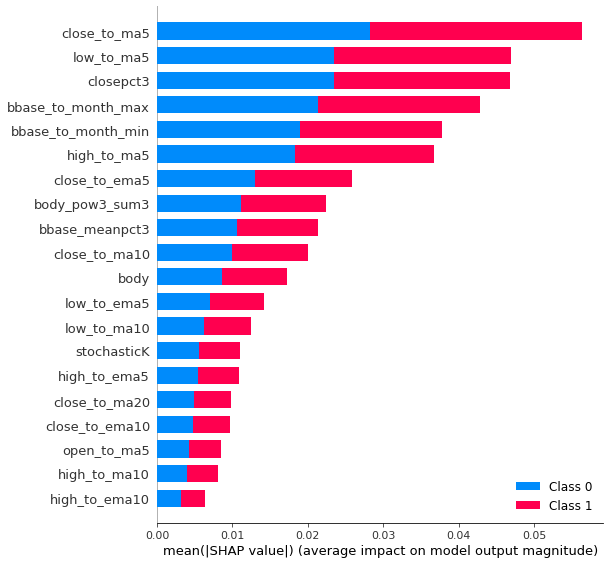

In [20]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(x_val)
shap.summary_plot(shap_values, feature_names = [col for col in stocks.get().columns if col != "y"])

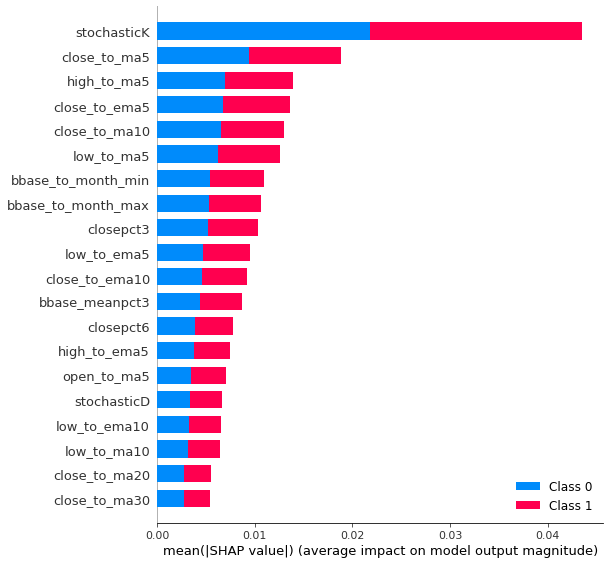

In [21]:
explainer = shap.TreeExplainer(extra)
shap_values = explainer.shap_values(x_val)
shap.summary_plot(shap_values, feature_names = [col for col in stocks.get().columns if col != "y"])

In [22]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_val)
shap.summary_plot(shap_values, feature_names = [col for col in stocks.get().columns if col != "y"])

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xca in position 209: invalid continuation byte

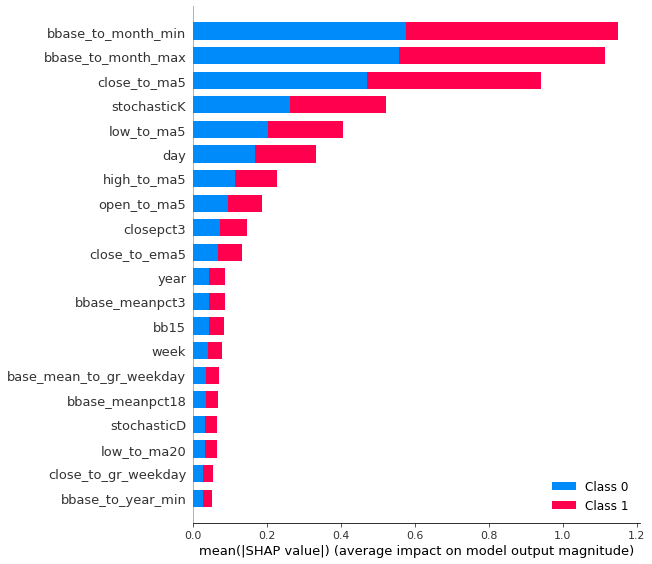

In [23]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(x_val)
shap.summary_plot(shap_values, feature_names = [col for col in stocks.get().columns if col != "y"])

# DL

In [24]:
x_train, y_train, x_val, y_val = stocks.split(.85, True)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((62607, 202), (62607,), (11061, 202), (11061,))

In [25]:
K.clear_session()
ffnn = Sequential(name="ffnn")
ffnn.add(layers.Dense(32, activation="relu", input_shape=x_train[0].shape))
ffnn.add(layers.Dense(16, activation="relu"))
ffnn.add(layers.Dense(1, activation="sigmoid"))

In [26]:
ffnn.summary()

Model: "ffnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                6496      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 7,041
Trainable params: 7,041
Non-trainable params: 0
_________________________________________________________________


In [27]:
ffnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [28]:
hist = ffnn.fit(x=x_train, y=y_train, batch_size=64, validation_data=(x_val, y_val), epochs=25)

Epoch 1/25
979/979 [==============================] - 3s 3ms/step - loss: 0.5622 - accuracy: 0.7108 - val_loss: 0.5276 - val_accuracy: 0.7334
Epoch 2/25
979/979 [==============================] - 3s 3ms/step - loss: 0.5270 - accuracy: 0.7370 - val_loss: 0.5282 - val_accuracy: 0.7379
Epoch 3/25
979/979 [==============================] - 3s 3ms/step - loss: 0.5187 - accuracy: 0.7423 - val_loss: 0.5144 - val_accuracy: 0.7429
Epoch 4/25
979/979 [==============================] - 3s 3ms/step - loss: 0.5130 - accuracy: 0.7454 - val_loss: 0.5107 - val_accuracy: 0.7423
Epoch 5/25
979/979 [==============================] - 3s 4ms/step - loss: 0.5077 - accuracy: 0.7484 - val_loss: 0.5072 - val_accuracy: 0.7500
Epoch 6/25
979/979 [==============================] - 3s 3ms/step - loss: 0.5043 - accuracy: 0.7513 - val_loss: 0.5054 - val_accuracy: 0.7469
Epoch 7/25
979/979 [==============================] - 3s 3ms/step - loss: 0.5001 - accuracy: 0.7529 - val_loss: 0.5056 - val_accuracy: 0.7521
Epoch 

In [29]:
go.Figure(data=[
    go.Scatter(y=hist.history["loss"], name="loss"),
    go.Scatter(y=hist.history["val_loss"], name="val_loss"),
    go.Scatter(y=hist.history["accuracy"], name="accuracy"),
    go.Scatter(y=hist.history["val_accuracy"], name="val_accuracy")
])

In [30]:
x_train, y_train, x_val, y_val = stocks.split(.85, True, 10)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((62445, 10, 202), (62445,), (10899, 10, 202), (10899,))

In [31]:
K.clear_session()

cnn = Sequential(name="cnn")

cnn.add(layers.Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=x_train[0].shape, padding="same"))
cnn.add(layers.Conv1D(filters=32, kernel_size=2, activation='relu', padding="same"))
cnn.add(layers.MaxPooling1D(pool_size=2, strides=1, padding="same"))

cnn.add(layers.GlobalAveragePooling1D())

cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dropout(.1))

cnn.add(layers.Dense(1))
cnn.add(layers.Activation("sigmoid"))

In [32]:
cnn.compile(optimizer=Adam(), loss="BinaryCrossentropy", metrics=["accuracy"])

In [33]:
hist = cnn.fit(x=x_train, y=y_train, validation_data=(x_val,y_val), epochs=25, batch_size=64)

Epoch 1/25
976/976 [==============================] - 5s 5ms/step - loss: 0.6157 - accuracy: 0.6507 - val_loss: 0.5545 - val_accuracy: 0.7156
Epoch 2/25
976/976 [==============================] - 4s 4ms/step - loss: 0.5349 - accuracy: 0.7313 - val_loss: 0.6337 - val_accuracy: 0.7370
Epoch 3/25
976/976 [==============================] - 5s 5ms/step - loss: 0.5227 - accuracy: 0.7402 - val_loss: 0.6632 - val_accuracy: 0.7444
Epoch 4/25
976/976 [==============================] - 4s 4ms/step - loss: 0.5163 - accuracy: 0.7441 - val_loss: 0.5208 - val_accuracy: 0.7455
Epoch 5/25
976/976 [==============================] - 4s 4ms/step - loss: 0.5117 - accuracy: 0.7479 - val_loss: 0.5269 - val_accuracy: 0.7492
Epoch 6/25
976/976 [==============================] - 4s 4ms/step - loss: 0.5091 - accuracy: 0.7481 - val_loss: 0.5347 - val_accuracy: 0.7470
Epoch 7/25
976/976 [==============================] - 4s 4ms/step - loss: 0.5048 - accuracy: 0.7515 - val_loss: 0.6555 - val_accuracy: 0.7497
Epoch 

In [34]:
go.Figure(data=[
    go.Scatter(y=hist.history["loss"], name="loss"),
    go.Scatter(y=hist.history["val_loss"], name="val_loss"),
    go.Scatter(y=hist.history["accuracy"], name="accuracy"),
    go.Scatter(y=hist.history["val_accuracy"], name="val_accuracy")
])

In [35]:
K.clear_session()
rnn = Sequential(name="rnn")

rnn.add(layers.LSTM(16, input_shape=x_train[0].shape, return_sequences=True, activation="relu"))
rnn.add(layers.LSTM(16, input_shape=x_train[0].shape, return_sequences=True, activation="relu"))

rnn.add(layers.Flatten())
rnn.add(layers.Dense(16, activation="relu"))
rnn.add(layers.Dense(1))

In [36]:
rnn.compile(optimizer=Adam(), loss="BinaryCrossentropy", metrics=["accuracy"])

In [37]:
hist = rnn.fit(x=x_train, y=y_train, validation_data=(x_val,y_val), epochs=25, batch_size=256)

Epoch 1/25
244/244 [==============================] - 11s 45ms/step - loss: 0.6948 - accuracy: 0.5838 - val_loss: 0.6984 - val_accuracy: 0.5803
Epoch 2/25
244/244 [==============================] - 10s 39ms/step - loss: 0.6505 - accuracy: 0.6334 - val_loss: 0.6741 - val_accuracy: 0.6446
Epoch 3/25
244/244 [==============================] - 10s 40ms/step - loss: 0.6161 - accuracy: 0.6664 - val_loss: 0.6134 - val_accuracy: 0.6939
Epoch 4/25
244/244 [==============================] - 9s 39ms/step - loss: 0.6080 - accuracy: 0.6733 - val_loss: 0.5930 - val_accuracy: 0.6941
Epoch 5/25
244/244 [==============================] - 9s 39ms/step - loss: 0.5785 - accuracy: 0.7022 - val_loss: 0.5829 - val_accuracy: 0.7074
Epoch 6/25
244/244 [==============================] - 10s 40ms/step - loss: 0.5773 - accuracy: 0.7007 - val_loss: 0.5727 - val_accuracy: 0.7124
Epoch 7/25
244/244 [==============================] - 11s 44ms/step - loss: 0.5716 - accuracy: 0.7055 - val_loss: 0.5642 - val_accuracy: 0

In [38]:
go.Figure(data=[
    go.Scatter(y=hist.history["loss"], name="loss"),
    go.Scatter(y=hist.history["val_loss"], name="val_loss"),
    go.Scatter(y=hist.history["accuracy"], name="accuracy"),
    go.Scatter(y=hist.history["val_accuracy"], name="val_accuracy")
])

In [39]:
1

1